In [3]:
import numpy as np
from numpy import sort
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from PIL import Image

To process the data, we define a function `process_data()` that reads the images from the directory and returns the train and test data. The function reads the images from the directory, resizes them to 150x150, converts them to numpy arrays, and appends them to a list. It also appends the target labels to another list. The function then reshapes the image data and splits it into train and test data. It returns the train and test data along with their corresponding labels.

In [4]:

BASE_DIRECTORY = './data/processed_data'


def process_data():
    """
    Process the data and return the train and test data
    """
    image_data = []
    targets = []

    for i, folder in enumerate(os.listdir(BASE_DIRECTORY)):  
        folder_path = os.path.join(BASE_DIRECTORY, folder)   
        for image_file in os.listdir(folder_path):      
            image_path = os.path.join(folder_path, image_file)  
            with Image.open(image_path) as img:
                img = img.resize((150, 150))
                img_array = np.array(img)
                image_data.append(img_array)
                targets.append(i)


    image_data = np.array(image_data)
    targets = np.array(targets)
    modified_data = image_data.reshape(-1, 22500)
    train_data, test_data, train_label, test_label = [], [], [], []

    for person in range(15):
        person_indices = np.where(targets == person)[0] 
        train_indices = person_indices[2:11]
        test_indices = person_indices[:2]
        train_data.extend(modified_data[train_indices])
        train_label.extend(targets[train_indices])
        test_data.extend(modified_data[test_indices])
        test_label.extend(targets[test_indices])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data) 
    test_label = np.array(test_label)
    return train_data, train_label, test_data, test_label 

The PCA function below performs Principal Component Analysis (PCA) on a dataset of images. It defines a function `PCA()` that takes in a data matrix with training data examples as rows and the number of principal components to keep. It then computes the mean face, subtracts the mean face from the data matrix, computes the SVD of the mean-centered data matrix, sorts the eigenvalues from largest to smallest, computes the weights of each data point, and returns the eigenfaces, weights, and mean face.

In [5]:
def PCA(A, num_components=0):
	"""
	Principal Component Analysis
	input: A, the data matrix with training data examples as rows
		   num_components, the number of principal components to keep
	"""
	[n,d] = A.shape 
	if (num_components <= 0) or (num_components>n):
		num_components = n
	mean_face = A.mean(axis=0)     			# Compute the mean face
	A = A - mean_face			    		# Subtract the mean face
	eigenfaces, eigenvalues, v = LA.linalg.svd(A.T, full_matrices=False) # Compute the SVD of the mean-centered data matrix
	idx = np . argsort ( - eigenvalues )	# Sort the eigenvalues from largest to smallest
	eigenfaces = eigenfaces [: , idx ]
	weights = np.dot(A, eigenfaces)			# Compute the weights of each data point
	return [eigenfaces, weights, mean_face]

In [6]:
def normalize(A, low, high, dtype=None):
    A = np.asarray(A)
    minA, maxA = np.min(A), np.max(A)
    A = A - float(minA)
    A = A / float((maxA - minA))
    A = A * (high - low)
    A = A + low
    if dtype is None:
        return np.asarray(A)
    return np.asarray(A, dtype=dtype)

We use this for ploting of the eigenfaces and to compare the actual and predicted images.

In [7]:
def subplot(title, images, rows, cols, sptitle="subplot", sptitles=[], colormap=cm.gray , ticks_visible=True, filename=None):
	"""
	Plots a list of images in a row.
	Used to plot the results of PCA, ICA and NMF in a row.
	"""
	fig = plt.figure()
	fig.text(.5, .95, title, horizontalalignment='center') 
	for i in range(len(images)):
		ax0 = fig.add_subplot(rows,cols,(i+1))
		plt.setp(ax0.get_xticklabels(), visible=False)
		plt.setp(ax0.get_yticklabels(), visible=False)
		if len(sptitles) == len(images):
			plt.title("%s #%s" % (sptitle, str(sptitles[i])))
		else:
			plt.title("%s #%d" % (sptitle, (i+1)))
		plt.imshow(np.asarray(images[i]).reshape(150, 150), cmap='gray')
	
	plt.show()

Given a face we substarct the mean face from the face and project it to the eigenfaces face space

In [8]:
def project_to_face_space(eigen_faces, a, mean_face=None):
	"""
	Project the image vector a into face space
	"""
	return np.dot(a- mean_face, eigen_faces)

Since the face is projected to face space using `np.dot(a - mean_face, eigen_faces)` we use the counter of this operation to reconstruct the face.

In [9]:
def reconstruct_faces(eigen_faces, a, mean_face=None): 
    """
    Reconstruct the image vector a from face space
    """
    return np.dot(a, eigen_faces.T) + mean_face

The `TrainEigenFaces` class trians the model by using the training dataset and also perfroms a perdiction given a face by using the Euclidean distance between the face and the projections of all faces.

In [16]:
class TrainEigenFaces:
    def __init__(self, eigenfaces, A=None, labels=None, num_components=0):
        self.num_components = 0
        self.projections = []
        self.threshold = 0
        self.U = eigenfaces
        self.mean_face = []
        if (A is not None) and (labels is not None):
            self.compute(A, labels)
    def distance(self, p, q):
        """
        Euclidean distance between two faces
        """
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return np.sqrt(np.sum(np.power((p - q), 2)))
    
    def compute(self, A, labels):
        [eigen_faces, weights, mean_face] = PCA(A)
        self.labels = labels
        self.mean_face = mean_face
        self.U = eigen_faces
        self.projections = weights
        diffs = self.projections[:, np.newaxis] - self.projections
    
        # Calculate norms for all differences
        norms = np.linalg.norm(diffs, axis=-1)
    
        # Find the maximum norm
        self.threshold = np.max(norms)
        print("threshold", self.threshold)

    def predict(self, A):
        minDist = np.finfo('float').max
        minClass = -1
        predicted_face = []
        status = ""
        Q = project_to_face_space(self.U, A, self.mean_face)
        for i in range(len(self.projections)):
            dist = self.distance(self.projections[i], Q)
            if dist < minDist:
                minDist = dist
                minClass = self.labels[i]
                predicted_face = self.projections[i]
        
        reconsturcted_face = reconstruct_faces(self.U, predicted_face, self.mean_face)
        e = LA.norm(np.abs(reconsturcted_face - A))
        if e >= self.threshold:
            status = "Not a face"
        elif e < self.threshold and minDist > self.threshold:
            status = "New face"
        else:
            status = "Known face"
        
        return minClass, predicted_face, status

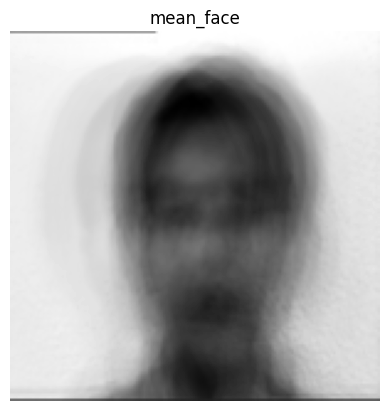

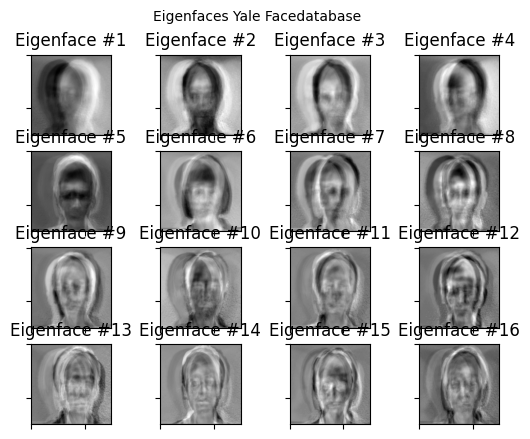

In [19]:
train_data, train_label, test_data, test_label = process_data()
[eigenfaces, weights, mean_face] = PCA(train_data)
plt.imshow(mean_face.reshape(150, 150), cmap='gray')
plt.title("mean_face")
plt.axis('off')
plt.show()
E = []
for i in range(min(len(train_data), 16)):
    e = eigenfaces[:,i].reshape(train_data[0].shape)
    E.append(normalize(e,0,255))
# plot them and store the plot to "python_eigenfaces.png"
subplot(title="Eigenfaces Yale Facedatabase", images=E, rows=4, cols=4, sptitle="Eigenface", colormap=cm.jet, filename="python_pca_eigenfaces.png")

We finally train the model and test it with the test image dataset and plot the actual image with its description.

In [17]:
trainded_model = TrainEigenFaces(eigenfaces, train_data, train_label)
count = 0
for i in range(len(test_data)):
    predicted, predicted_face, status = trainded_model.predict(test_data[i])
    if predicted == test_label[i]:
        count += 1
print("Accuracy", (count/len(test_data)) * 100)


threshold 25249.497796985972
Accuracy 80.0


We can now plot some images from the test data along with their prediction to see the output.

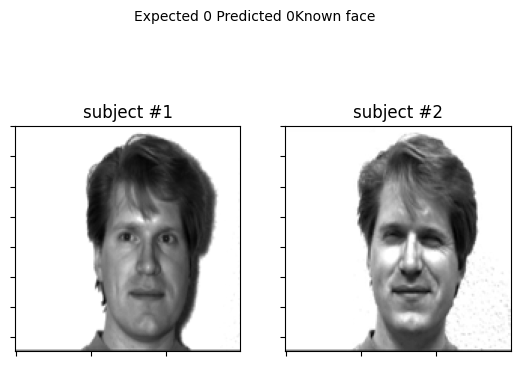

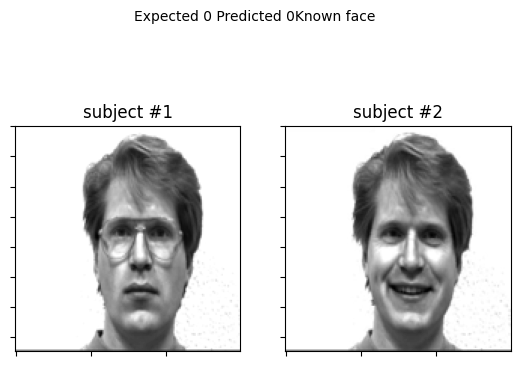

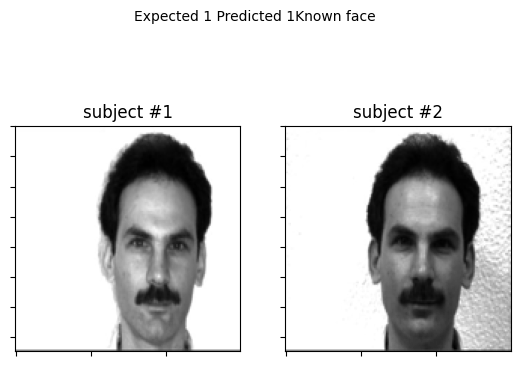

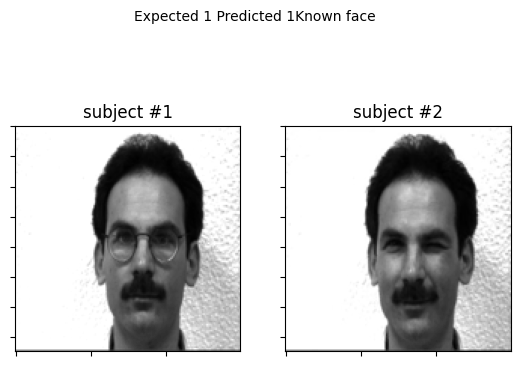

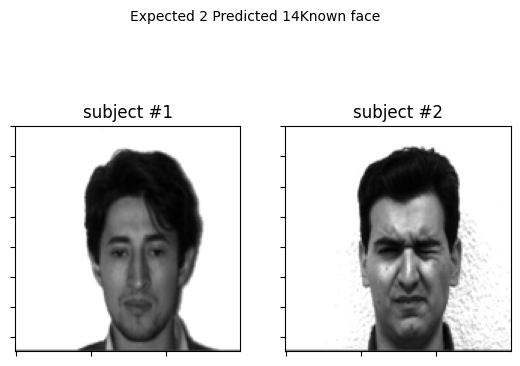

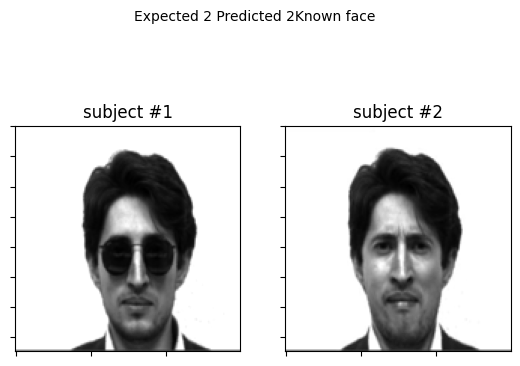

In [18]:
for i in range(6):
    predicted, predicted_face, status = trainded_model.predict(test_data[i])
    subplot(title="Expected "+str(test_label[i])+" Predicted "+str(predicted) + status, images=[test_data[i], reconstruct_faces(eigenfaces, predicted_face, mean_face)], rows=1, cols=2, sptitle="subject", colormap=cm.gray, filename="python_pca_reconstruction_subject_"+str(i)+".png")